# Exploratory Data Analysis

## Imports and constants

In [1]:
%load_ext autoreload
%autoreload 2

import os
from typing import Dict, Any
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
from transformers import AutoTokenizer
from datasets import load_dataset

from defi_textmine_2025.data.problem_formulation import (    
    TextToMultiLabelDataGenerator,
    Mention2TypeDataGenerator
)
from defi_textmine_2025.data.utils import (
    load_labeled_raw_data,
    load_test_raw_data,
    clean_raw_dataset,
    print_value_types,
    save_data,
    convert_text_to_entity_spans
)
from defi_textmine_2025.data.utils import TARGET_COL, INPUT_COLS, INTERIM_DIR, EDA_DIR

VALIDATION_RATE = 0.25
BASE_CHECKPOINT = "camembert/camembert-base"

tokenizer = AutoTokenizer.from_pretrained(BASE_CHECKPOINT)
def count_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])

[06:18:52|INFO|config.py:58] PyTorch version 2.3.1 available.
[06:18:52|INFO|config.py:105] TensorFlow version 2.16.2 available.
/home/tagny/.pyenv/versions/3.11.9/envs/kaggle/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Loading data

In [2]:
labeled_raw_df = load_labeled_raw_data()
labeled_raw_df

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{""id"": 0, ""mentions"": [{""value"": ""accident"", ...","[[0, ""STARTED_IN"", 9], [7, ""IS_LOCATED_IN"", 9]..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{""id"": 0, ""mentions"": [{""value"": ""explosé"", ""...","[[9, ""IS_LOCATED_IN"", 8], [11, ""OPERATES_IN"", ..."
51470,"En Espagne, dans une région agricole, une cont...","[{""id"": 0, ""mentions"": [{""value"": ""contaminati...","[[7, ""IS_PART_OF"", 8], [9, ""OPERATES_IN"", 1], ..."
51332,Un important incendie a fait des ravages dans ...,"[{""id"": 0, ""mentions"": [{""value"": ""incendie"", ...","[[12, ""IS_IN_CONTACT_WITH"", 5], [0, ""IS_LOCATE..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{""id"": 0, ""mentions"": [{""value"": ""renversé"", ...","[[9, ""IS_LOCATED_IN"", 2], [0, ""START_DATE"", 17..."
...,...,...,...
1288,"M. Thibault Alekseï, membre de l'association ""...","[{""id"": 0, ""mentions"": [{""value"": ""perdu le co...","[[2, ""IS_PART_OF"", 3], [12, ""IS_IN_CONTACT_WIT..."
3822,Des employés d'une usine de production médical...,"[{""id"": 0, ""mentions"": [{""value"": ""grève"", ""st...","[[8, ""HAS_CONTROL_OVER"", 7], [4, ""HAS_CATEGORY..."
51266,"Le 13 mars 2001, Belgrade a connu un krach bou...","[{""id"": 0, ""mentions"": [{""value"": ""krach bours...","[[1, ""STARTED_IN"", 3], [10, ""IS_PART_OF"", 4], ..."


In [3]:
test_raw_df = load_test_raw_data()
test_raw_df

,text,entities
id,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{""id"": 0, ""mentions"": [{""value"": ""crash"", ""st..."
4909,"48 heures après le braquage du ""DC Supermarket...","[{""id"": 0, ""mentions"": [{""value"": ""DC Supermar..."
2353,"À Genève, la boîte de nuit ""Pretty Woman"" a en...","[{""id"": 0, ""mentions"": [{""value"": ""tombé"", ""st..."
1210,"À Caracas, l'an dernier, une mine située à l'o...","[{""id"": 0, ""mentions"": [{""value"": ""effondremen..."
41948,"À Genève, une industrie de fabrication d'arbre...","[{""id"": 0, ""mentions"": [{""value"": ""incendiée"",..."
...,...,...
51452,"Le WOOP, une organisation mondiale, avait prop...","[{""id"": 0, ""mentions"": [{""value"": ""épidémie"", ..."
51491,"Madame Pautrat Elina, dirigeante de l’associat...","[{""id"": 0, ""mentions"": [{""value"": ""pollution"",..."
51492,"Monsieur Elirone Trameur, membre de l’associat...","[{""id"": 0, ""mentions"": [{""value"": ""pollution"",..."


## Analysing raw data

### Check value types

In [4]:
labeled_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 181 to 124
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       800 non-null    object
 1   entities   800 non-null    object
 2   relations  800 non-null    object
dtypes: object(3)
memory usage: 25.0+ KB


In [5]:
test_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1204 to 51742
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      400 non-null    object
 1   entities  400 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


In [6]:
# types of values in train data
print_value_types(labeled_raw_df)

text <class 'str'>
entities <class 'str'>
relations <class 'str'>


In [7]:
# types of values in test data
print_value_types(test_raw_df)

text <class 'str'>
entities <class 'str'>


### Check for duplicated rows

In [8]:
labeled_raw_df[labeled_raw_df.duplicated()]

,text,entities,relations
id,,,


In [9]:
test_raw_df[test_raw_df.duplicated()]

,text,entities
id,,


### Check for missing values

In [10]:
labeled_raw_df.isnull().sum()

text         0
entities     0
relations    0
dtype: int64

In [11]:
test_raw_df.isnull().sum()

text        0
entities    0
dtype: int64

In [12]:
labeled_raw_df.relations.sort_values()

id
41601    [[0, "DEATHS_NUMBER", 14], [3, "RESIDES_IN", 4...
2514     [[0, "END_DATE", 11], [0, "IS_LOCATED_IN", 4],...
1223     [[0, "END_DATE", 11], [10, "START_DATE", 11], ...
2329     [[0, "END_DATE", 11], [4, "RESIDES_IN", 1], [0...
3898     [[0, "END_DATE", 9], [5, "OPERATES_IN", 7], [1...
                               ...                        
4964     [[9, "IS_LOCATED_IN", 5], [8, "OPERATES_IN", 5...
41071    [[9, "IS_LOCATED_IN", 5], [9, "IS_LOCATED_IN",...
31669    [[9, "IS_LOCATED_IN", 8], [11, "OPERATES_IN", ...
41918    [[9, "IS_LOCATED_IN", 8], [13, "HAS_CONTROL_OV...
155      [[9, "OPERATES_IN", 1], [0, "IS_LOCATED_IN", 4...
Name: relations, Length: 800, dtype: object

## Data Cleaning/Wrangling

### Fix value typing

In [13]:
labeled_clean_df = clean_raw_dataset(labeled_raw_df)
test_clean_df = clean_raw_dataset(test_raw_df)

In [14]:
assert (labeled_raw_df.index == labeled_clean_df.index).all()
assert (test_raw_df.index == test_clean_df.index).all()

In [15]:
test_raw_df.head(1)

,text,entities
id,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{""id"": 0, ""mentions"": [{""value"": ""crash"", ""st..."


In [16]:
test_clean_df.head(1)

,text,entities,relations
id,,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{'id': 0, 'mentions': [{'value': 'crash', 'st...",None


### Check value types

In [17]:
# types of values in train data
print_value_types(labeled_clean_df)

text <class 'str'>
entities [  [<class 'str'>, <class 'str'>, <class 'str'>]  ]
relations [  <class 'list'>  ]


In [18]:
# types of values in test data
print_value_types(test_clean_df)

text <class 'str'>
entities [  [<class 'str'>, <class 'str'>, <class 'str'>]  ]
relations <class 'NoneType'>


### Save cleaned datasets

For manual analysis

In [19]:
save_data(labeled_clean_df, os.path.join(INTERIM_DIR, "train_cleaned.csv"))
save_data(test_clean_df, os.path.join(INTERIM_DIR, "test_cleaned.csv"))

## Analyze clean data

### All relation types

In [20]:
relation_classes = set(
    sum(
        labeled_clean_df.relations.apply(
            lambda row: list({r for (e1, r, e2) in row})
        ).values.tolist(),
        [],
    )
)
print(len(relation_classes))
relation_classes

37


{'CREATED',
 'DEATHS_NUMBER',
 'DIED_IN',
 'END_DATE',
 'GENDER_FEMALE',
 'GENDER_MALE',
 'HAS_CATEGORY',
 'HAS_COLOR',
 'HAS_CONSEQUENCE',
 'HAS_CONTROL_OVER',
 'HAS_FAMILY_RELATIONSHIP',
 'HAS_FOR_HEIGHT',
 'HAS_FOR_LENGTH',
 'HAS_FOR_WIDTH',
 'HAS_LATITUDE',
 'HAS_LONGITUDE',
 'HAS_QUANTITY',
 'INITIATED',
 'INJURED_NUMBER',
 'IS_AT_ODDS_WITH',
 'IS_BORN_IN',
 'IS_BORN_ON',
 'IS_COOPERATING_WITH',
 'IS_DEAD_ON',
 'IS_IN_CONTACT_WITH',
 'IS_LOCATED_IN',
 'IS_OF_NATIONALITY',
 'IS_OF_SIZE',
 'IS_PART_OF',
 'IS_REGISTERED_AS',
 'OPERATES_IN',
 'RESIDES_IN',
 'STARTED_IN',
 'START_DATE',
 'WAS_CREATED_IN',
 'WAS_DISSOLVED_IN',
 'WEIGHS'}

#### Summary stats on relation classes

<Axes: xlabel='Number of texts containing the relation', ylabel='Relation'>

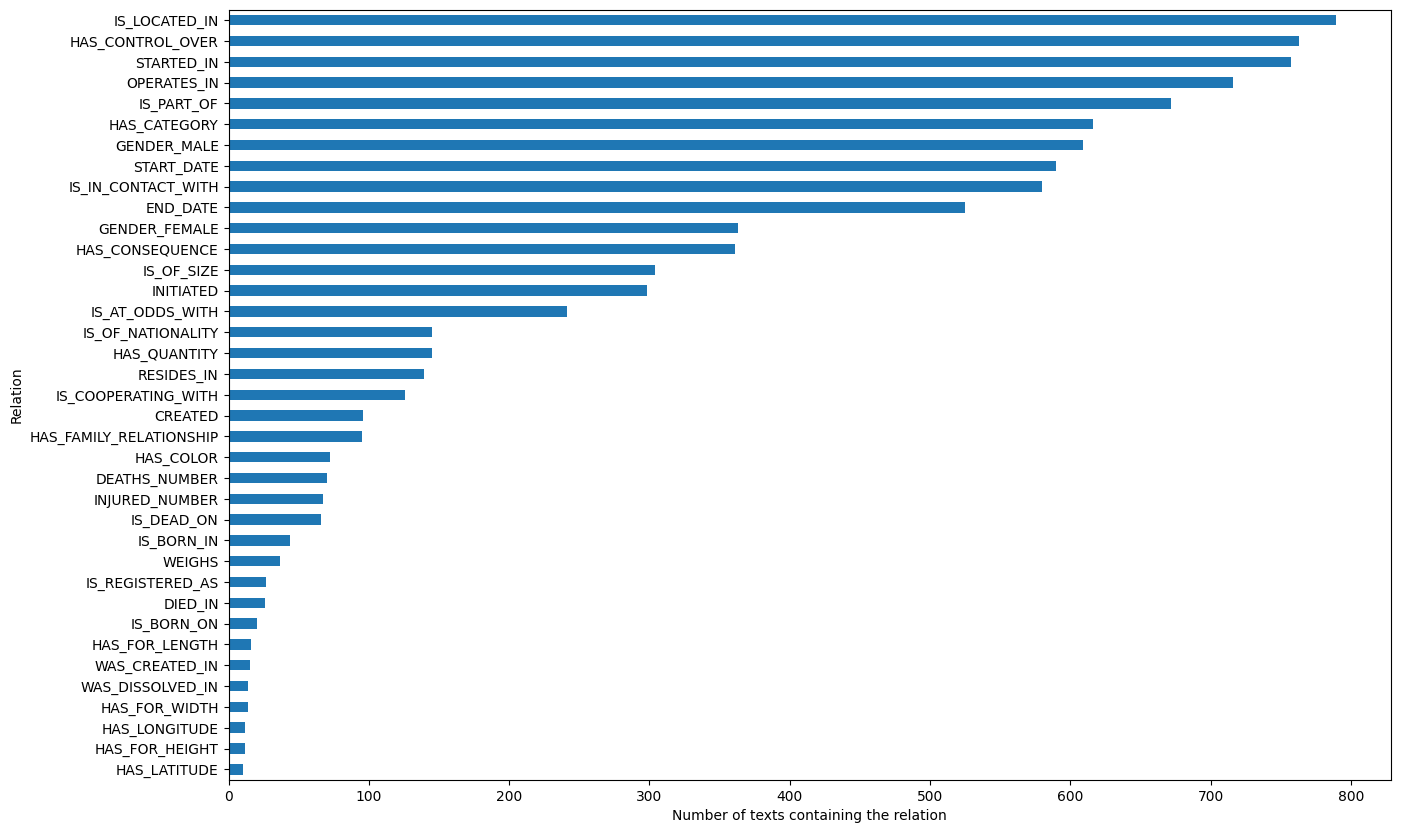

In [21]:
# number of text containing a relation category

plt.figure(figsize=(15, 10))
n_texts_per_relation_type = pd.Series({cat: labeled_raw_df[labeled_raw_df.relations.str.contains(cat)].shape[0] for cat in relation_classes}).sort_values(ascending=True)
n_texts_per_relation_type.plot.barh(xlabel="Number of texts containing the relation", ylabel="Relation")

#### number of relation instances per text

In [22]:
nb_rel_occur_per_text_df = pd.DataFrame({cat: labeled_raw_df.relations.str.count(cat) for cat in relation_classes})
nb_rel_occur_per_text_df

,INITIATED,START_DATE,GENDER_MALE,IS_LOCATED_IN,IS_IN_CONTACT_WITH,RESIDES_IN,HAS_FOR_WIDTH,END_DATE,HAS_FOR_LENGTH,IS_BORN_IN,...,HAS_QUANTITY,IS_COOPERATING_WITH,DIED_IN,DEATHS_NUMBER,STARTED_IN,IS_BORN_ON,CREATED,IS_OF_SIZE,WEIGHS,IS_REGISTERED_AS
id,,,,,,,,,,,,,,,,,,,,,
181,0,1,2,17,0,0,0,1,0,0,...,0,0,0,0,2,0,0,2,0,0
31669,0,3,2,14,0,0,0,3,0,0,...,1,0,0,0,8,0,0,0,0,0
51470,0,1,1,5,2,0,0,0,0,0,...,0,2,0,0,3,0,2,0,0,0
51332,1,0,2,3,2,0,0,0,0,0,...,1,0,0,0,2,0,0,0,0,0
1131,0,2,1,8,2,0,0,1,1,0,...,0,0,0,0,4,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,0,3,1,14,4,0,0,3,0,0,...,0,0,0,0,3,0,0,0,0,0
3822,0,0,1,6,4,0,0,0,0,0,...,0,0,0,0,1,0,0,2,0,0
51266,0,3,2,7,0,0,0,0,0,0,...,1,0,0,0,3,0,0,0,1,0


In [23]:
# distribution of the occurences of each category among texts
nb_rel_occur_per_text_df.describe().T.sort_values("50%", ascending=False)

,count,mean,std,min,25%,50%,75%,max
IS_LOCATED_IN,800.0,11.28125,6.555025,0.0,7.0,10.0,15.0,44.0
HAS_CONTROL_OVER,800.0,5.68375,3.724389,0.0,3.0,5.0,8.0,22.0
IS_IN_CONTACT_WITH,800.0,3.64875,4.583026,0.0,0.0,2.0,4.0,44.0
OPERATES_IN,800.0,3.04375,2.650588,0.0,1.0,2.0,4.0,19.0
STARTED_IN,800.0,2.32500,1.829223,0.0,1.0,2.0,3.0,12.0
HAS_CATEGORY,800.0,1.11750,0.891452,0.0,1.0,1.0,2.0,5.0
GENDER_MALE,800.0,1.13500,0.864702,0.0,1.0,1.0,2.0,4.0
END_DATE,800.0,1.09250,1.081853,0.0,0.0,1.0,2.0,6.0
START_DATE,800.0,1.29250,1.165608,0.0,0.0,1.0,2.0,7.0
IS_PART_OF,800.0,1.82750,1.642747,0.0,1.0,1.0,2.0,14.0


#### Number of instances per relation type

In [24]:
nb_rel_occur_per_text_df.sum(axis=0).sort_values()

HAS_LATITUDE                 10
HAS_FOR_HEIGHT               12
HAS_LONGITUDE                12
HAS_FOR_WIDTH                14
WAS_DISSOLVED_IN             14
WAS_CREATED_IN               15
HAS_FOR_LENGTH               16
IS_BORN_ON                   20
IS_REGISTERED_AS             34
DIED_IN                      41
WEIGHS                       41
IS_BORN_IN                   50
IS_DEAD_ON                   68
INJURED_NUMBER               70
DEATHS_NUMBER                75
HAS_COLOR                    91
CREATED                     141
IS_OF_NATIONALITY           179
HAS_QUANTITY                191
RESIDES_IN                  222
HAS_FAMILY_RELATIONSHIP     222
IS_COOPERATING_WITH         372
GENDER_FEMALE               414
IS_OF_SIZE                  438
INITIATED                   469
HAS_CONSEQUENCE             769
END_DATE                    874
HAS_CATEGORY                894
GENDER_MALE                 908
START_DATE                 1034
IS_PART_OF                 1462
IS_AT_OD

In [25]:
labeled_raw_df.relations.str.count("IS_LOCATED_IN")

id
181      17
31669    14
51470     5
51332     3
1131      8
         ..
1288     14
3822      6
51266     7
51368    13
124      23
Name: relations, Length: 800, dtype: int64

In [26]:
labeled_clean_df.relations.loc[181]

[[0, 'STARTED_IN', 9],
 [7, 'IS_LOCATED_IN', 9],
 [5, 'IS_LOCATED_IN', 10],
 [1, 'GENDER_FEMALE', 1],
 [12, 'IS_LOCATED_IN', 10],
 [0, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 10],
 [13, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 10],
 [1, 'HAS_CATEGORY', 18],
 [5, 'IS_LOCATED_IN', 9],
 [9, 'IS_LOCATED_IN', 10],
 [14, 'IS_DEAD_ON', 15],
 [7, 'HAS_CATEGORY', 19],
 [12, 'IS_LOCATED_IN', 9],
 [0, 'IS_LOCATED_IN', 9],
 [7, 'GENDER_MALE', 7],
 [11, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 9],
 [14, 'HAS_CATEGORY', 20],
 [0, 'STARTED_IN', 10],
 [0, 'START_DATE', 15],
 [7, 'IS_LOCATED_IN', 10],
 [0, 'END_DATE', 15],
 [14, 'GENDER_MALE', 14],
 [12, 'IS_OF_SIZE', 22],
 [13, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 11],
 [13, 'IS_OF_SIZE', 21]]

In [27]:
# Total occurences of each category in the labeled dataset
pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=False)

IS_LOCATED_IN              9025
HAS_CONTROL_OVER           4547
IS_IN_CONTACT_WITH         2919
OPERATES_IN                2435
STARTED_IN                 1860
IS_AT_ODDS_WITH            1526
IS_PART_OF                 1462
START_DATE                 1034
GENDER_MALE                 908
HAS_CATEGORY                894
END_DATE                    874
HAS_CONSEQUENCE             769
INITIATED                   469
IS_OF_SIZE                  438
GENDER_FEMALE               414
IS_COOPERATING_WITH         372
HAS_FAMILY_RELATIONSHIP     222
RESIDES_IN                  222
HAS_QUANTITY                191
IS_OF_NATIONALITY           179
CREATED                     141
HAS_COLOR                    91
DEATHS_NUMBER                75
INJURED_NUMBER               70
IS_DEAD_ON                   68
IS_BORN_IN                   50
DIED_IN                      41
WEIGHS                       41
IS_REGISTERED_AS             34
IS_BORN_ON                   20
HAS_FOR_LENGTH               16
WAS_CREA

<Axes: title={'center': 'Total occurences of each category in the labeled dataset'}, xlabel='Number of labeled relations of a given category', ylabel='Category of relation'>

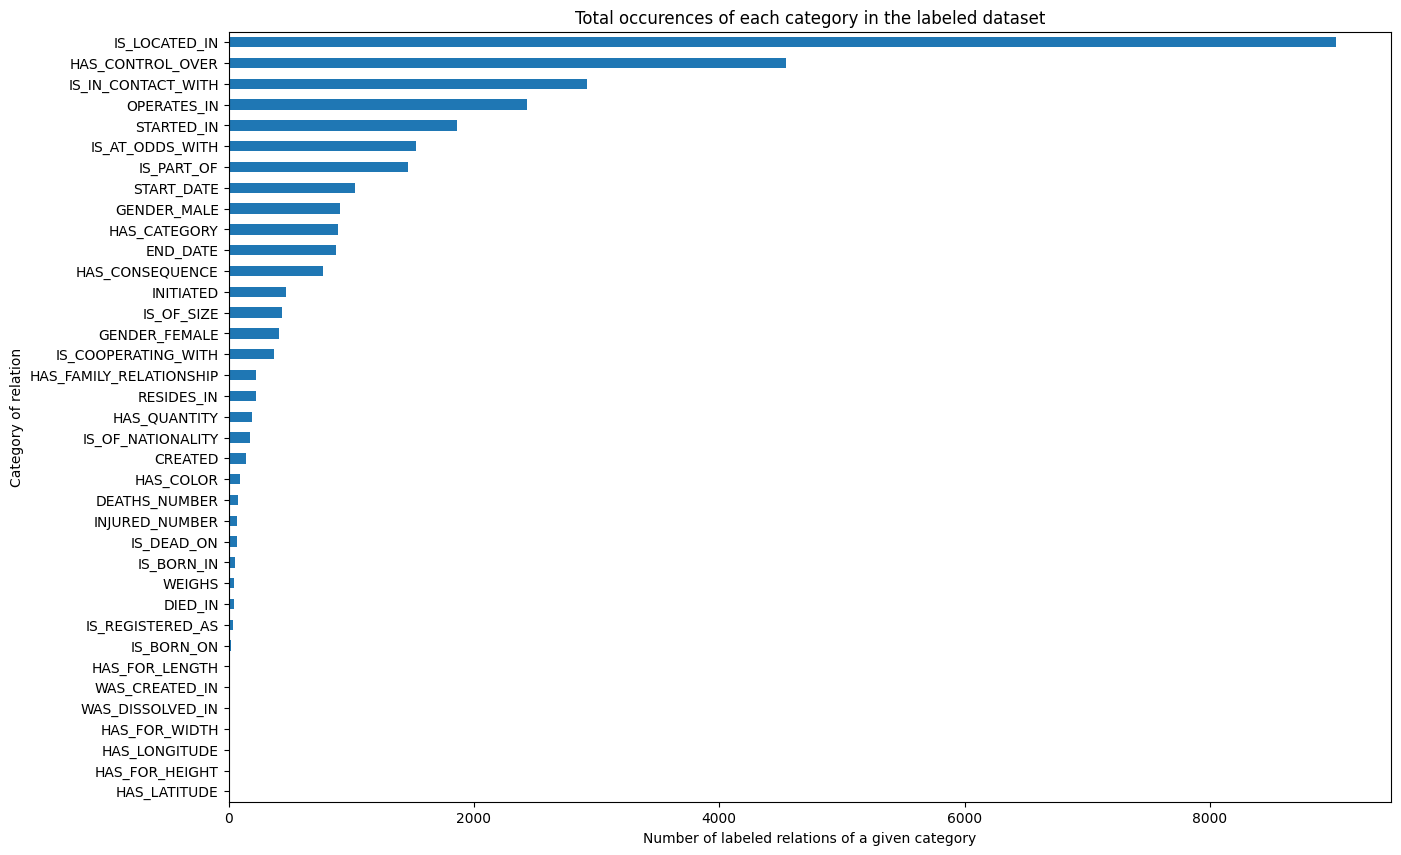

In [28]:
plt.figure(figsize=(15, 10))
pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=True).plot.barh(xlabel="Number of labeled relations of a given category", ylabel="Category of relation", title="Total occurences of each category in the labeled dataset")
# pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=False)

#### How many relations can we expect to extract from a text?

count    800.00000
mean      39.33625
std       17.50339
min        4.00000
25%       27.00000
50%       37.00000
75%       48.00000
max      143.00000
Name: relations, dtype: float64


<Axes: >

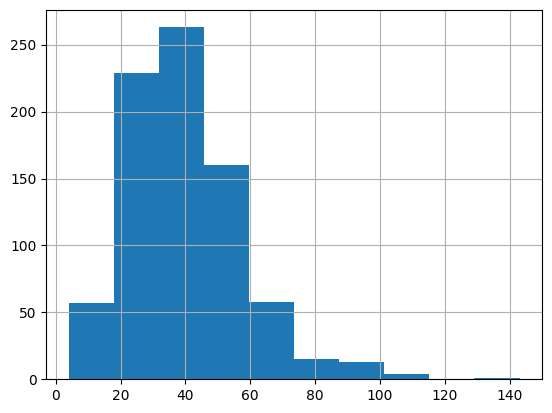

In [29]:
n_relations_per_text_df = labeled_clean_df.relations.map(lambda x: len(x))
print(n_relations_per_text_df.describe())
n_relations_per_text_df.hist()

### All entity types

In [30]:
entity_classes = set(
    sum(
        labeled_clean_df.entities.apply(
            lambda row: list({e["type"] for e in row})
        ).values.tolist(),
        [],
    )
)
print(len(entity_classes))
entity_classes

55


{'ACCIDENT',
 'AGITATING_TROUBLE_MAKING',
 'BOMBING',
 'CATEGORY',
 'CBRN_EVENT',
 'CIVILIAN',
 'CIVIL_WAR_OUTBREAK',
 'COLOR',
 'COUP_D_ETAT',
 'CRIMINAL_ARREST',
 'DEMONSTRATION',
 'DRUG_OPERATION',
 'ECONOMICAL_CRISIS',
 'ELECTION',
 'EPIDEMIC',
 'FIRE',
 'FIRSTNAME',
 'GATHERING',
 'GROUP_OF_INDIVIDUALS',
 'HEIGHT',
 'HOOLIGANISM_TROUBLEMAKING',
 'ILLEGAL_CIVIL_DEMONSTRATION',
 'INTERGOVERNMENTAL_ORGANISATION',
 'LASTNAME',
 'LATITUDE',
 'LENGTH',
 'LONGITUDE',
 'MATERIAL_REFERENCE',
 'MATERIEL',
 'MILITARY',
 'MILITARY_ORGANISATION',
 'NATIONALITY',
 'NATURAL_CAUSES_DEATH',
 'NATURAL_EVENT',
 'NON_GOVERNMENTAL_ORGANISATION',
 'NON_MILITARY_GOVERNMENT_ORGANISATION',
 'PLACE',
 'POLITICAL_VIOLENCE',
 'POLLUTION',
 'QUANTITY_EXACT',
 'QUANTITY_FUZZY',
 'QUANTITY_MAX',
 'QUANTITY_MIN',
 'RIOT',
 'STRIKE',
 'SUICIDE',
 'TERRORIST_OR_CRIMINAL',
 'THEFT',
 'TIME_EXACT',
 'TIME_FUZZY',
 'TIME_MAX',
 'TIME_MIN',
 'TRAFFICKING',
 'WEIGHT',
 'WIDTH'}

#### Summary stats on entity classes

* entity type frequencies

In [31]:
labeled_raw_df[labeled_raw_df.entities.str.contains("MATERIEL")].head()

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{""id"": 0, ""mentions"": [{""value"": ""accident"", ...","[[0, ""STARTED_IN"", 9], [7, ""IS_LOCATED_IN"", 9]..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{""id"": 0, ""mentions"": [{""value"": ""explosé"", ""...","[[9, ""IS_LOCATED_IN"", 8], [11, ""OPERATES_IN"", ..."
51470,"En Espagne, dans une région agricole, une cont...","[{""id"": 0, ""mentions"": [{""value"": ""contaminati...","[[7, ""IS_PART_OF"", 8], [9, ""OPERATES_IN"", 1], ..."
51332,Un important incendie a fait des ravages dans ...,"[{""id"": 0, ""mentions"": [{""value"": ""incendie"", ...","[[12, ""IS_IN_CONTACT_WITH"", 5], [0, ""IS_LOCATE..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{""id"": 0, ""mentions"": [{""value"": ""renversé"", ...","[[9, ""IS_LOCATED_IN"", 2], [0, ""START_DATE"", 17..."


<Axes: xlabel='Number of texts containing the entity', ylabel='Entity'>

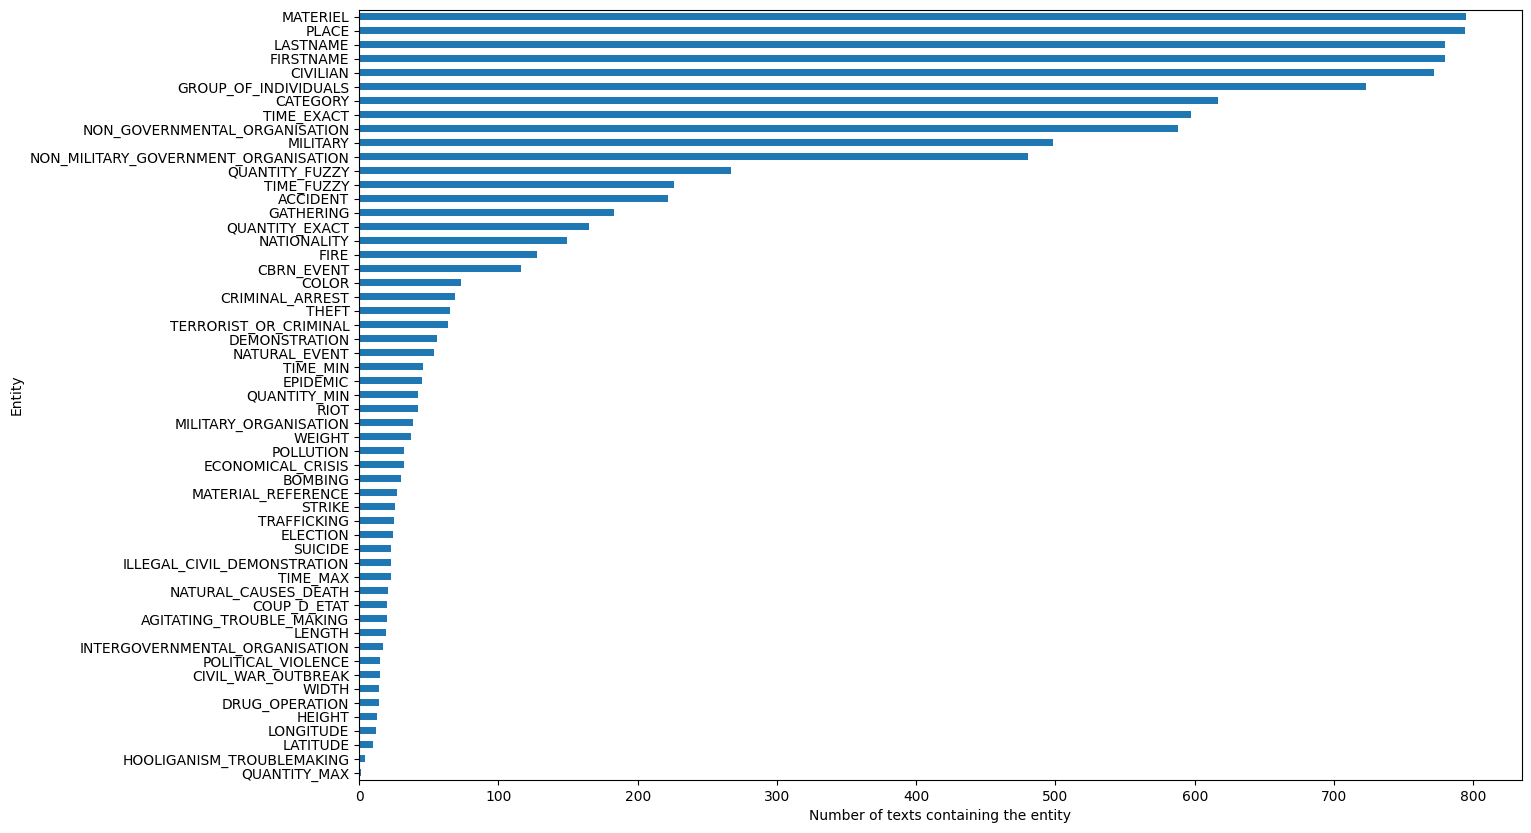

In [32]:
plt.figure(figsize=(15, 10))
n_texts_per_entity_type = pd.Series({cat: labeled_raw_df[labeled_raw_df.entities.str.contains(cat)].shape[0] for cat in entity_classes}).sort_values(ascending=True)
n_texts_per_entity_type.plot.barh(xlabel="Number of texts containing the entity", ylabel="Entity")

### Stats about the cooccurence between entity categories and relation categories

For each relation category:
- what is the number of time each entity category is e1?
- what is the number of time each entity category is e2?
- what pairs of entity categories are never into a relation?

In [33]:
labeled_clean_df.values

array([['Anam Destresse, président de l\'ONG "Ma passion", a été blessé dans un accident. Le 30 juin 2022, un accident de circulation s\'est produit entre une moto et un bus sur l\'autoroute de Saint-Marin en Italie. Le bus, qui transportait 20 passagers, appartenait à l\'ONG. Lors de l\'accident, les panneaux de signalisation ont été complètement endommagés et le garde du corps a été blessé. Au total, deux passagers sont morts sur le coup. Anam Destresse, qui faisait partie des blessés, a été transporté en hélicoptère jusqu\'à l\'hôpital. Le conducteur de la moto a été retrouvé mort en dessous du bus. Il conduisait sans permis et en état d\'ivresse.',
        list([{'id': 0, 'mentions': [{'value': 'accident', 'start': 70, 'end': 78}, {'value': 'accident de circulation', 'start': 100, 'end': 123}, {'value': 'accident', 'start': 275, 'end': 283}], 'type': 'ACCIDENT'}, {'id': 1, 'mentions': [{'value': 'Anam Destresse', 'start': 0, 'end': 14}, {'value': 'Anam Destresse', 'start': 431, 'en

In [34]:
for text_idx, text, text_entities, text_relations in labeled_clean_df.reset_index().values:
    pass

In [35]:

entity_relation_cat_df  = pd.concat(
    [
        pd.DataFrame([[text_idx, text_entities[e1_id]["type"], r_cat, text_entities[e2_id]["type"]] for e1_id, r_cat, e2_id in text_relations], columns=["text_id", "e1_cat", "r_cat", "e2_cat"])
        for text_idx, text, text_entities, text_relations in labeled_clean_df.reset_index().values
    ],
    axis=0
)
logging.info(f"{entity_relation_cat_df.shape=}")
entity_relation_cat_df.head()

[06:19:21|INFO|16258189.py:8] entity_relation_cat_df.shape=(31469, 4)


,text_id,e1_cat,r_cat,e2_cat
0,181,ACCIDENT,STARTED_IN,PLACE
1,181,CIVILIAN,IS_LOCATED_IN,PLACE
2,181,GROUP_OF_INDIVIDUALS,IS_LOCATED_IN,PLACE
3,181,CIVILIAN,GENDER_FEMALE,CIVILIAN
4,181,GROUP_OF_INDIVIDUALS,IS_LOCATED_IN,PLACE


In [36]:
print(len(relation_classes), relation_classes)
print(len(entity_classes), entity_classes)

37 {'INITIATED', 'START_DATE', 'GENDER_MALE', 'IS_LOCATED_IN', 'IS_IN_CONTACT_WITH', 'RESIDES_IN', 'HAS_FOR_WIDTH', 'END_DATE', 'HAS_FOR_LENGTH', 'IS_BORN_IN', 'HAS_CONSEQUENCE', 'WAS_DISSOLVED_IN', 'HAS_LONGITUDE', 'IS_DEAD_ON', 'HAS_CATEGORY', 'HAS_COLOR', 'HAS_CONTROL_OVER', 'WAS_CREATED_IN', 'INJURED_NUMBER', 'OPERATES_IN', 'IS_OF_NATIONALITY', 'IS_AT_ODDS_WITH', 'HAS_LATITUDE', 'IS_PART_OF', 'GENDER_FEMALE', 'HAS_FOR_HEIGHT', 'HAS_FAMILY_RELATIONSHIP', 'HAS_QUANTITY', 'IS_COOPERATING_WITH', 'DIED_IN', 'DEATHS_NUMBER', 'STARTED_IN', 'IS_BORN_ON', 'CREATED', 'IS_OF_SIZE', 'WEIGHS', 'IS_REGISTERED_AS'}
55 {'TIME_FUZZY', 'DRUG_OPERATION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'GATHERING', 'LASTNAME', 'CATEGORY', 'TIME_MAX', 'ACCIDENT', 'TIME_MIN', 'QUANTITY_EXACT', 'HEIGHT', 'LONGITUDE', 'PLACE', 'QUANTITY_MAX', 'CRIMINAL_ARREST', 'HOOLIGANISM_TROUBLEMAKING', 'AGITATING_TROUBLE_MAKING', 'THEFT', 'TERRORIST_OR_CRIMINAL', 'MILITARY', 'SUICIDE', 'CIVILIAN', 'WEIGHT', 'NON_GOVERNMENTAL_ORGANISAT

In [37]:
entity_relation_cat_df.query("r_cat=='HAS_CONTROL_OVER'").e1_cat.value_counts(normalize=True)

e1_cat
CIVILIAN                                0.399604
GROUP_OF_INDIVIDUALS                    0.378051
NON_MILITARY_GOVERNMENT_ORGANISATION    0.100946
NON_GOVERNMENTAL_ORGANISATION           0.064878
TERRORIST_OR_CRIMINAL                   0.038707
MILITARY_ORGANISATION                   0.010336
MILITARY                                0.005938
INTERGOVERNMENTAL_ORGANISATION          0.001320
PLACE                                   0.000220
Name: proportion, dtype: float64

In [38]:
entity_relation_cat_df.query("r_cat=='HAS_CONTROL_OVER'").e2_cat.value_counts(normalize=True)

e2_cat
MATERIEL                                0.603035
PLACE                                   0.244117
NON_GOVERNMENTAL_ORGANISATION           0.071476
GROUP_OF_INDIVIDUALS                    0.038487
CIVILIAN                                0.020893
NON_MILITARY_GOVERNMENT_ORGANISATION    0.014295
TERRORIST_OR_CRIMINAL                   0.005058
MILITARY_ORGANISATION                   0.001979
MILITARY                                0.000440
INTERGOVERNMENTAL_ORGANISATION          0.000220
Name: proportion, dtype: float64

#### For a relation, how many times is an entity category e1 or e2?

In [39]:
# plt.figure(figsize=(15, 10))
df = pd.concat([entity_relation_cat_df.value_counts(normalize=False), entity_relation_cat_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_relation_classes = len(relation_classes)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing relations vs. {n_entity_classes * n_relation_classes * n_entity_classes=} imaginable relations !")
df.to_csv(os.path.join(EDA_DIR, "e1_cat-r_cat-e2_cat-freq.csv")) #.plot.barh()
df

[06:19:22|INFO|39938676.py:5] 17820 existing relations vs. n_entity_classes * n_relation_classes * n_entity_classes=111925 imaginable relations !


,text_id,e1_cat,r_cat,e2_cat,count,proportion
0,3656,GROUP_OF_INDIVIDUALS,IS_LOCATED_IN,PLACE,25,0.000794
1,41533,GROUP_OF_INDIVIDUALS,IS_LOCATED_IN,PLACE,22,0.000699
2,51250,ECONOMICAL_CRISIS,HAS_CONSEQUENCE,ECONOMICAL_CRISIS,21,0.000667
3,144,GROUP_OF_INDIVIDUALS,IS_LOCATED_IN,PLACE,21,0.000667
4,11883,NON_MILITARY_GOVERNMENT_ORGANISATION,OPERATES_IN,PLACE,19,0.000604
...,...,...,...,...,...,...
17815,3821,NON_MILITARY_GOVERNMENT_ORGANISATION,HAS_CONTROL_OVER,GROUP_OF_INDIVIDUALS,1,0.000032
17816,3821,NON_MILITARY_GOVERNMENT_ORGANISATION,HAS_CONTROL_OVER,MATERIEL,1,0.000032
17817,3821,NON_MILITARY_GOVERNMENT_ORGANISATION,IS_AT_ODDS_WITH,GROUP_OF_INDIVIDUALS,1,0.000032
17818,3821,PLACE,IS_LOCATED_IN,PLACE,1,0.000032


In [40]:
entity_relation_cat_df.query("r_cat=='STARTED_IN'").drop("r_cat", axis=1).value_counts().rename("count_STARTED_IN")

text_id  e1_cat                       e2_cat
2431     ACCIDENT                     PLACE     9
2347     ACCIDENT                     PLACE     8
51367    FIRE                         PLACE     7
31755    CBRN_EVENT                   PLACE     6
17       ACCIDENT                     PLACE     6
                                               ..
3872     ILLEGAL_CIVIL_DEMONSTRATION  PLACE     1
3879     SUICIDE                      PLACE     1
3881     GATHERING                    PLACE     1
         SUICIDE                      PLACE     1
52002    TRAFFICKING                  PLACE     1
Name: count_STARTED_IN, Length: 1124, dtype: int64

In [41]:
entity_relation_cat_df.query("r_cat=='WAS_CREATED_IN'").drop("r_cat", axis=1).value_counts()

text_id  e1_cat                                e2_cat    
1131     MATERIEL                              TIME_EXACT    1
1211     MATERIEL                              TIME_EXACT    1
2331     NON_GOVERNMENTAL_ORGANISATION         TIME_EXACT    1
2363     NON_GOVERNMENTAL_ORGANISATION         TIME_EXACT    1
2443     MATERIEL                              TIME_EXACT    1
3605     NON_GOVERNMENTAL_ORGANISATION         TIME_EXACT    1
3689     NON_MILITARY_GOVERNMENT_ORGANISATION  TIME_EXACT    1
3780     MATERIEL                              TIME_MIN      1
3887     MATERIEL                              TIME_EXACT    1
3891     MATERIEL                              TIME_EXACT    1
4934     MATERIEL                              TIME_EXACT    1
11521    NON_GOVERNMENTAL_ORGANISATION         TIME_EXACT    1
41203    NON_GOVERNMENTAL_ORGANISATION         TIME_EXACT    1
41819    MATERIEL                              TIME_EXACT    1
41938    MATERIEL                              TIME_FUZZY   

In [42]:
entity_relation_cat_df.query("e2_cat=='TIME_EXACT'").drop(["e1_cat", "e2_cat"], axis=1).value_counts()

text_id  r_cat           
51247    START_DATE          7
51250    START_DATE          7
51216    START_DATE          6
41783    END_DATE            6
         START_DATE          6
                            ..
3696     START_DATE          1
         WAS_DISSOLVED_IN    1
3701     END_DATE            1
         START_DATE          1
51907    START_DATE          1
Name: count, Length: 1106, dtype: int64

In [43]:
entity_relation_cat_df.query("e2_cat=='TIME_FUZZY'").drop(["e1_cat", "e2_cat"], axis=1).value_counts()

text_id  r_cat     
31866    START_DATE    3
         END_DATE      3
11876    START_DATE    3
         END_DATE      3
51356    END_DATE      3
                      ..
3807     START_DATE    1
         IS_DEAD_ON    1
         END_DATE      1
3759     START_DATE    1
51953    START_DATE    1
Name: count, Length: 123, dtype: int64

In [44]:
# number of relation categories between a pair of entity categories
entity_relation_cat_df.drop_duplicates().groupby(["e1_cat", "e2_cat"]).count().sort_values(by="r_cat")

text_id  r_cat
e1_cat               e2_cat                                       
GATHERING            DEMONSTRATION                        1      1
CIVIL_WAR_OUTBREAK   TIME_FUZZY                           1      1
COUP_D_ETAT          AGITATING_TROUBLE_MAKING             1      1
                     BOMBING                              1      1
GATHERING            POLITICAL_VIOLENCE                   1      1
...                                                     ...    ...
CIVILIAN             GROUP_OF_INDIVIDUALS               675    675
                     NON_GOVERNMENTAL_ORGANISATION      739    739
GROUP_OF_INDIVIDUALS PLACE                              888    888
CIVILIAN             PLACE                             1081   1081
                     CIVILIAN                          1222   1222

[474 rows x 2 columns]

#### what pairs of entity categories are in any relationship in the train dataset?

In [45]:
entity_cat_pair_in_relation_df = entity_relation_cat_df[["e1_cat", "e2_cat"]]#.drop_duplicates(subset=["e1_cat", "e2_cat"])
entity_cat_pair_in_relation_df

,e1_cat,e2_cat
0,ACCIDENT,PLACE
1,CIVILIAN,PLACE
2,GROUP_OF_INDIVIDUALS,PLACE
3,CIVILIAN,CIVILIAN
4,GROUP_OF_INDIVIDUALS,PLACE
...,...,...
64,GROUP_OF_INDIVIDUALS,GROUP_OF_INDIVIDUALS
65,ACCIDENT,PLACE
66,FIRE,TIME_EXACT
67,GROUP_OF_INDIVIDUALS,PLACE


In [46]:
df = pd.concat([entity_cat_pair_in_relation_df.value_counts(normalize=False), entity_cat_pair_in_relation_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing entity category pairs in relation vs. {n_entity_classes * n_entity_classes=} imaginable entity category pairs !")
df.to_csv(os.path.join(EDA_DIR, "e1_cat-e2_cat-freq.csv")) #.plot.barh()
df

[06:19:24|INFO|871775664.py:3] 474 existing entity category pairs in relation vs. n_entity_classes * n_entity_classes=3025 imaginable entity category pairs !


,e1_cat,e2_cat,count,proportion
0,GROUP_OF_INDIVIDUALS,PLACE,3411,0.108392
1,CIVILIAN,PLACE,2717,0.086339
2,CIVILIAN,CIVILIAN,1895,0.060218
3,NON_MILITARY_GOVERNMENT_ORGANISATION,PLACE,1372,0.043598
4,PLACE,PLACE,1319,0.041914
...,...,...,...,...
469,POLITICAL_VIOLENCE,DEMONSTRATION,1,0.000032
470,EPIDEMIC,BOMBING,1,0.000032
471,EPIDEMIC,DEMONSTRATION,1,0.000032
472,PLACE,MATERIEL,1,0.000032


### How many times the relation involves 2 entities of the same type?

In [47]:
e1_cat_equal_e2_cat_df = entity_cat_pair_in_relation_df.query("e1_cat==e2_cat")
e1_cat_equal_e2_cat_df

,e1_cat,e2_cat
3,CIVILIAN,CIVILIAN
11,PLACE,PLACE
16,CIVILIAN,CIVILIAN
17,PLACE,PLACE
25,TERRORIST_OR_CRIMINAL,TERRORIST_OR_CRIMINAL
...,...,...
30,PLACE,PLACE
36,PLACE,PLACE
52,PLACE,PLACE
60,CIVILIAN,CIVILIAN


In [48]:
df = pd.concat([e1_cat_equal_e2_cat_df.value_counts(normalize=False), e1_cat_equal_e2_cat_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing entity of identical categories in relation vs. {n_entity_classes=} imaginable entity category !")
df.to_csv(os.path.join(EDA_DIR, "e1_cat-equal-e2_cat-freq.csv")) #.plot.barh()
df

[06:19:24|INFO|1690103560.py:3] 29 existing entity of identical categories in relation vs. n_entity_classes=55 imaginable entity category !


,e1_cat,e2_cat,count,proportion
0,CIVILIAN,CIVILIAN,1895,0.412225
1,PLACE,PLACE,1319,0.286926
2,GROUP_OF_INDIVIDUALS,GROUP_OF_INDIVIDUALS,842,0.183163
3,ECONOMICAL_CRISIS,ECONOMICAL_CRISIS,97,0.021101
4,NON_GOVERNMENTAL_ORGANISATION,NON_GOVERNMENTAL_ORGANISATION,89,0.019360
5,TERRORIST_OR_CRIMINAL,TERRORIST_OR_CRIMINAL,77,0.016750
6,ACCIDENT,ACCIDENT,69,0.015010
7,NON_MILITARY_GOVERNMENT_ORGANISATION,NON_MILITARY_GOVERNMENT_ORGANISATION,56,0.012182
8,CBRN_EVENT,CBRN_EVENT,26,0.005656
9,MILITARY,MILITARY,22,0.004786


In [49]:
per_r_cat_e1_cat_equal_e2_cat_df = entity_relation_cat_df.query("e1_cat==e2_cat")
per_r_cat_e1_cat_equal_e2_cat_df

,text_id,e1_cat,r_cat,e2_cat
3,181,CIVILIAN,GENDER_FEMALE,CIVILIAN
11,181,PLACE,IS_LOCATED_IN,PLACE
16,181,CIVILIAN,GENDER_MALE,CIVILIAN
17,181,PLACE,IS_LOCATED_IN,PLACE
25,181,TERRORIST_OR_CRIMINAL,GENDER_MALE,TERRORIST_OR_CRIMINAL
...,...,...,...,...
30,124,PLACE,IS_LOCATED_IN,PLACE
36,124,PLACE,IS_LOCATED_IN,PLACE
52,124,PLACE,IS_LOCATED_IN,PLACE
60,124,CIVILIAN,GENDER_FEMALE,CIVILIAN


In [50]:
df = pd.concat([per_r_cat_e1_cat_equal_e2_cat_df.value_counts(normalize=False), per_r_cat_e1_cat_equal_e2_cat_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing entity of identical categories in relation vs. {n_entity_classes=} imaginable entity category !")
df.to_csv(os.path.join(EDA_DIR, "per_r_cat-e1_cat-equal-e2_cat_df-freq.csv")) #.plot.barh()
df

[06:19:25|INFO|2498074872.py:3] 2537 existing entity of identical categories in relation vs. n_entity_classes=55 imaginable entity category !


,text_id,e1_cat,r_cat,e2_cat,count,proportion
0,51250,ECONOMICAL_CRISIS,HAS_CONSEQUENCE,ECONOMICAL_CRISIS,21,0.004568
1,51224,ECONOMICAL_CRISIS,HAS_CONSEQUENCE,ECONOMICAL_CRISIS,15,0.003263
2,4944,GROUP_OF_INDIVIDUALS,IS_IN_CONTACT_WITH,GROUP_OF_INDIVIDUALS,12,0.002610
3,51424,GROUP_OF_INDIVIDUALS,IS_IN_CONTACT_WITH,GROUP_OF_INDIVIDUALS,12,0.002610
4,51276,GROUP_OF_INDIVIDUALS,IS_COOPERATING_WITH,GROUP_OF_INDIVIDUALS,12,0.002610
...,...,...,...,...,...,...
2532,41095,CIVILIAN,GENDER_MALE,CIVILIAN,1,0.000218
2533,41089,POLITICAL_VIOLENCE,HAS_CONSEQUENCE,POLITICAL_VIOLENCE,1,0.000218
2534,2450,PLACE,IS_LOCATED_IN,PLACE,1,0.000218
2535,41089,GROUP_OF_INDIVIDUALS,IS_PART_OF,GROUP_OF_INDIVIDUALS,1,0.000218


#### what pairs of entity categories never have any relationship?

- we don't need to attempt to classify pairs of entities of these types

In [51]:
all_possible_entity_cat_pairs_df = pd.DataFrame([[e1_cat, e2_cat] for (e1_cat, e2_cat) in itertools.product(*[list(entity_classes)]*2)], columns=["e1_cat", "e2_cat"]).set_index(["e1_cat", "e2_cat"])
all_possible_entity_cat_pairs_df

Empty DataFrame
Columns: []
Index: [(TIME_FUZZY, TIME_FUZZY), (TIME_FUZZY, DRUG_OPERATION), (TIME_FUZZY, ILLEGAL_CIVIL_DEMONSTRATION), (TIME_FUZZY, GATHERING), (TIME_FUZZY, LASTNAME), (TIME_FUZZY, CATEGORY), (TIME_FUZZY, TIME_MAX), (TIME_FUZZY, ACCIDENT), (TIME_FUZZY, TIME_MIN), (TIME_FUZZY, QUANTITY_EXACT), (TIME_FUZZY, HEIGHT), (TIME_FUZZY, LONGITUDE), (TIME_FUZZY, PLACE), (TIME_FUZZY, QUANTITY_MAX), (TIME_FUZZY, CRIMINAL_ARREST), (TIME_FUZZY, HOOLIGANISM_TROUBLEMAKING), (TIME_FUZZY, AGITATING_TROUBLE_MAKING), (TIME_FUZZY, THEFT), (TIME_FUZZY, TERRORIST_OR_CRIMINAL), (TIME_FUZZY, MILITARY), (TIME_FUZZY, SUICIDE), (TIME_FUZZY, CIVILIAN), (TIME_FUZZY, WEIGHT), (TIME_FUZZY, NON_GOVERNMENTAL_ORGANISATION), (TIME_FUZZY, RIOT), (TIME_FUZZY, LATITUDE), (TIME_FUZZY, NATURAL_CAUSES_DEATH), (TIME_FUZZY, POLLUTION), (TIME_FUZZY, CIVIL_WAR_OUTBREAK), (TIME_FUZZY, TIME_EXACT), (TIME_FUZZY, NATURAL_EVENT), (TIME_FUZZY, WIDTH), (TIME_FUZZY, FIRE), (TIME_FUZZY, NON_MILITARY_GOVERNMENT_ORGANISATION), (TIME_FUZZY, COUP_D_ETAT), (TIME_FUZZY, INTERGOVERNMENTAL_ORGANISATION), (TIME_FUZZY, MATERIEL), (TIME_FUZZY, ECONOMICAL_CRISIS), (TIME_FUZZY, ELECTION), (TIME_FUZZY, LENGTH), (TIME_FUZZY, MATERIAL_REFERENCE), (TIME_FUZZY, TRAFFICKING), (TIME_FUZZY, BOMBING), (TIME_FUZZY, QUANTITY_FUZZY), (TIME_FUZZY, FIRSTNAME), (TIME_FUZZY, QUANTITY_MIN), (TIME_FUZZY, GROUP_OF_INDIVIDUALS), (TIME_FUZZY, CBRN_EVENT), (TIME_FUZZY, STRIKE), (TIME_FUZZY, POLITICAL_VIOLENCE), (TIME_FUZZY, COLOR), (TIME_FUZZY, MILITARY_ORGANISATION), (TIME_FUZZY, DEMONSTRATION), (TIME_FUZZY, NATIONALITY), (TIME_FUZZY, EPIDEMIC), (DRUG_OPERATION, TIME_FUZZY), (DRUG_OPERATION, DRUG_OPERATION), (DRUG_OPERATION, ILLEGAL_CIVIL_DEMONSTRATION), (DRUG_OPERATION, GATHERING), (DRUG_OPERATION, LASTNAME), (DRUG_OPERATION, CATEGORY), (DRUG_OPERATION, TIME_MAX), (DRUG_OPERATION, ACCIDENT), (DRUG_OPERATION, TIME_MIN), (DRUG_OPERATION, QUANTITY_EXACT), (DRUG_OPERATION, HEIGHT), (DRUG_OPERATION, LONGITUDE), (DRUG_OPERATION, PLACE), (DRUG_OPERATION, QUANTITY_MAX), (DRUG_OPERATION, CRIMINAL_ARREST), (DRUG_OPERATION, HOOLIGANISM_TROUBLEMAKING), (DRUG_OPERATION, AGITATING_TROUBLE_MAKING), (DRUG_OPERATION, THEFT), (DRUG_OPERATION, TERRORIST_OR_CRIMINAL), (DRUG_OPERATION, MILITARY), (DRUG_OPERATION, SUICIDE), (DRUG_OPERATION, CIVILIAN), (DRUG_OPERATION, WEIGHT), (DRUG_OPERATION, NON_GOVERNMENTAL_ORGANISATION), (DRUG_OPERATION, RIOT), (DRUG_OPERATION, LATITUDE), (DRUG_OPERATION, NATURAL_CAUSES_DEATH), (DRUG_OPERATION, POLLUTION), (DRUG_OPERATION, CIVIL_WAR_OUTBREAK), (DRUG_OPERATION, TIME_EXACT), (DRUG_OPERATION, NATURAL_EVENT), (DRUG_OPERATION, WIDTH), (DRUG_OPERATION, FIRE), (DRUG_OPERATION, NON_MILITARY_GOVERNMENT_ORGANISATION), (DRUG_OPERATION, COUP_D_ETAT), (DRUG_OPERATION, INTERGOVERNMENTAL_ORGANISATION), (DRUG_OPERATION, MATERIEL), (DRUG_OPERATION, ECONOMICAL_CRISIS), (DRUG_OPERATION, ELECTION), (DRUG_OPERATION, LENGTH), (DRUG_OPERATION, MATERIAL_REFERENCE), (DRUG_OPERATION, TRAFFICKING), (DRUG_OPERATION, BOMBING), (DRUG_OPERATION, QUANTITY_FUZZY), (DRUG_OPERATION, FIRSTNAME), ...]

[3025 rows x 0 columns]

In [52]:
entity_cat_pair_in_relation_df.drop_duplicates().set_index(["e1_cat", "e2_cat"])

,
e1_cat,e2_cat
ACCIDENT,PLACE
CIVILIAN,PLACE
GROUP_OF_INDIVIDUALS,PLACE
CIVILIAN,CIVILIAN
TERRORIST_OR_CRIMINAL,PLACE
...,...
CIVILIAN,COUP_D_ETAT
MILITARY,COUP_D_ETAT
COUP_D_ETAT,QUANTITY_FUZZY


In [53]:
entity_pairs_never_in_relation_df = pd.DataFrame(index=all_possible_entity_cat_pairs_df.index.difference(entity_cat_pair_in_relation_df.drop_duplicates().set_index(["e1_cat", "e2_cat"]).index)).reset_index(drop=False)
entity_pairs_never_in_relation_df.to_csv(os.path.join(EDA_DIR, "entity_pairs_never_in_relation.csv"))
entity_pairs_never_in_relation_df

,e1_cat,e2_cat
0,ACCIDENT,AGITATING_TROUBLE_MAKING
1,ACCIDENT,BOMBING
2,ACCIDENT,CATEGORY
3,ACCIDENT,CIVILIAN
4,ACCIDENT,CIVIL_WAR_OUTBREAK
...,...,...
2546,WIDTH,TIME_MAX
2547,WIDTH,TIME_MIN
2548,WIDTH,TRAFFICKING
2549,WIDTH,WEIGHT


### What are the entity types involved in minority relation types

... for data augmentation by entity replacement

In [54]:
text, text_entities, text_relations = labeled_clean_df.iloc[100].to_list()
text

"Des jeunes habitants des quartiers populaires de Paris ont vu une vidéo dénonçant des violences policières, publiée par Monsieur Alain Dupond sur les réseaux sociaux le 2 septembre 2023. Les jeunes révoltés se sont donc réunis en petits groupes et ont décidé d'exprimer leur colère en saccageant les voitures de police et les biens des bourgeois blancs. Ils se déplaçaient de nuit dans la ville au guidon de leurs motos et jetaient des cocktails Molotov sur les véhicules de patrouille. Certains étaient même équipés d'armes à feu et tiraient sur les façades des maisons, d'autres se promenaient à pied et déchiraient les roues des voitures avec leur canif tandis que d'autres encore explosaient les pare-brise à grands coups de batte de baseball. Les populations apeurées cherchaient à alerter la police avec leurs téléphones."

In [55]:
text_entities[0]

{'id': 0,
 'mentions': [{'value': 'réunis', 'start': 220, 'end': 226}],
 'type': 'RIOT'}

In [56]:
convert_text_to_entity_spans(text, text_entities)

[('Des jeunes ', None),
 ('habitants', 2),
 (' des ', None),
 ('quartiers populaires', 12),
 (' de ', None),
 ('Paris', 11),
 (' ont vu une vidéo dénonçant des violences ', None),
 ('policières', 3),
 (', publiée par Monsieur ', None),
 ('Alain', 21),
 (' ', None),
 ('Dupond', 20),
 (' sur les réseaux sociaux le ', None),
 ('2 septembre 2023', 19),
 ('. Les ', None),
 ('jeunes révoltés', 2),
 (' se sont donc ', None),
 ('réunis', 0),
 (' en petits ', None),
 ('groupes', 2),
 (" et ont décidé d'exprimer leur colère en saccageant les ", None),
 ('voitures', 4),
 (' de ', None),
 ('police', 10),
 (' et les ', None),
 ('biens', 5),
 (' des ', None),
 ('bourgeois blancs', 13),
 ('. ', None),
 ('Ils', 2),
 (' se déplaçaient de nuit dans la ', None),
 ('ville', 11),
 (' au guidon de leurs ', None),
 ('motos', 6),
 (' et jetaient des ', None),
 ('cocktails Molotov', 14),
 (' sur les ', None),
 ('véhicules de patrouille', 15),
 ('. ', None),
 ('Certains', 2),
 (" étaient même équipés d'", None)

<Axes: >

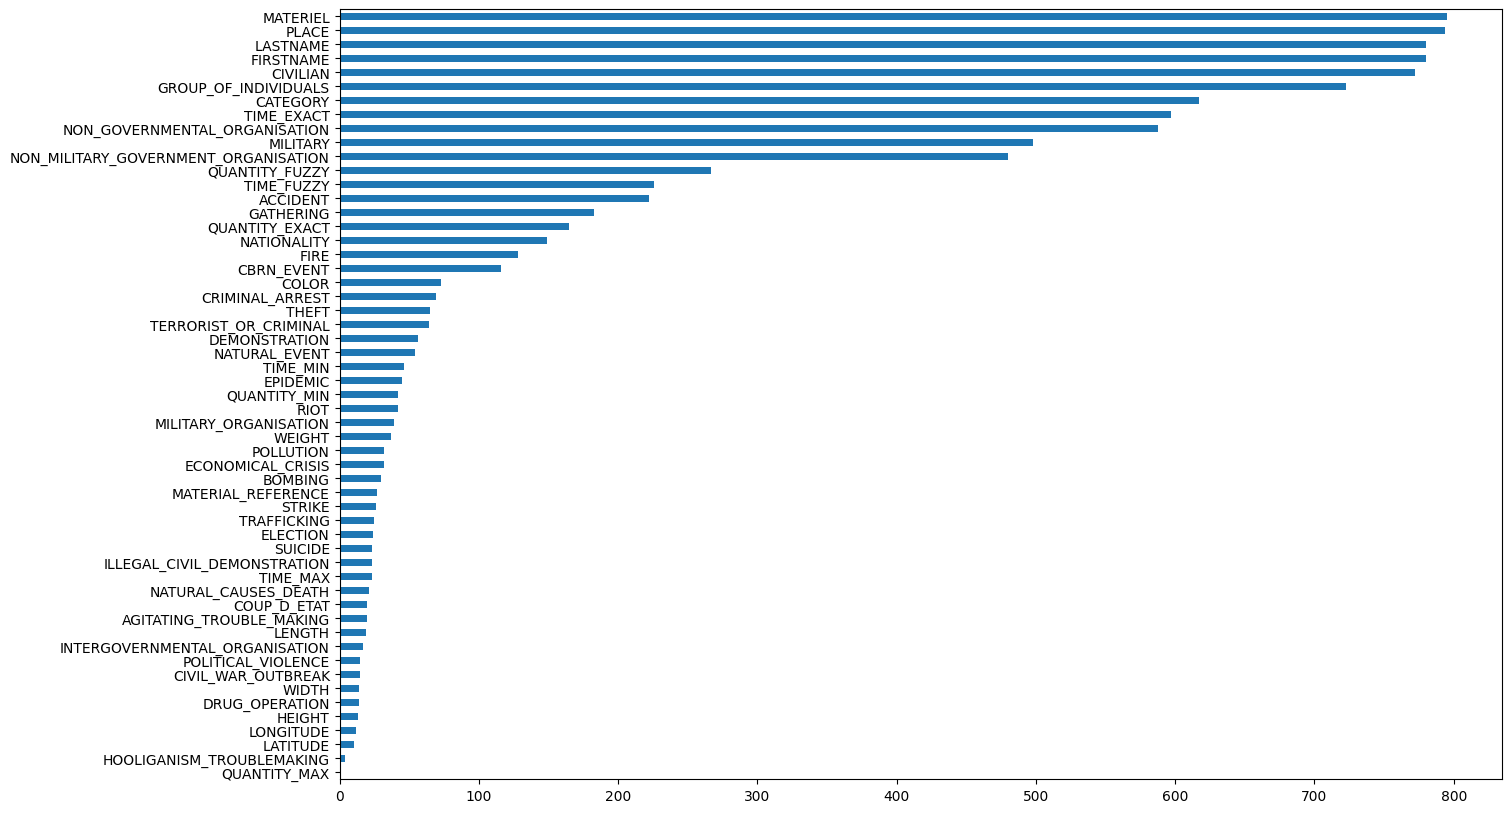

In [57]:
plt.figure(figsize=(15, 10))
n_texts_per_entity_type.plot.barh()

In [58]:
entity_relation_cat_df.query("e2_cat=='COLOR'")#.shape[0]

,text_id,e1_cat,r_cat,e2_cat
33,31669,MATERIEL,HAS_COLOR,COLOR
4,3766,MATERIEL,HAS_COLOR,COLOR
7,3766,MATERIEL,HAS_COLOR,COLOR
36,41889,MATERIEL,HAS_COLOR,COLOR
19,3804,MATERIEL,HAS_COLOR,COLOR
...,...,...,...,...
30,41048,MATERIEL,HAS_COLOR,COLOR
14,1109,MATERIEL,HAS_COLOR,COLOR
19,4987,MATERIEL,HAS_COLOR,COLOR
5,41204,MATERIEL,HAS_COLOR,COLOR


In [59]:
entity_relation_cat_df.query("e1_cat=='MATERIEL'").shape[0]

408

In [60]:
entity_relation_cat_df.query("r_cat=='HAS_CONSEQUENCE'").shape[0]

769

In [61]:
entity_relation_cat_df.query("r_cat=='GENDER_FEMALE'")#.shape[0]

,text_id,e1_cat,r_cat,e2_cat
3,181,CIVILIAN,GENDER_FEMALE,CIVILIAN
13,1131,CIVILIAN,GENDER_FEMALE,CIVILIAN
17,3622,CIVILIAN,GENDER_FEMALE,CIVILIAN
22,3766,CIVILIAN,GENDER_FEMALE,CIVILIAN
0,1116,CIVILIAN,GENDER_FEMALE,CIVILIAN
...,...,...,...,...
11,1252,CIVILIAN,GENDER_FEMALE,CIVILIAN
32,51398,CIVILIAN,GENDER_FEMALE,CIVILIAN
43,2570,CIVILIAN,GENDER_FEMALE,CIVILIAN
35,3678,CIVILIAN,GENDER_FEMALE,CIVILIAN


In [62]:
print(n_texts_per_relation_type.rename("n_examples").to_frame().query("n_examples < 500").index.shape[0])
n_texts_per_relation_type.rename("n_examples").to_frame().query("n_examples < 500")

27


,n_examples
HAS_LATITUDE,10
HAS_FOR_HEIGHT,12
HAS_LONGITUDE,12
HAS_FOR_WIDTH,14
WAS_DISSOLVED_IN,14
WAS_CREATED_IN,15
HAS_FOR_LENGTH,16
IS_BORN_ON,20
DIED_IN,26
IS_REGISTERED_AS,27


In [63]:
n_texts_per_relation_type.index

Index(['HAS_LATITUDE', 'HAS_FOR_HEIGHT', 'HAS_LONGITUDE', 'HAS_FOR_WIDTH',
       'WAS_DISSOLVED_IN', 'WAS_CREATED_IN', 'HAS_FOR_LENGTH', 'IS_BORN_ON',
       'DIED_IN', 'IS_REGISTERED_AS', 'WEIGHS', 'IS_BORN_IN', 'IS_DEAD_ON',
       'INJURED_NUMBER', 'DEATHS_NUMBER', 'HAS_COLOR',
       'HAS_FAMILY_RELATIONSHIP', 'CREATED', 'IS_COOPERATING_WITH',
       'RESIDES_IN', 'HAS_QUANTITY', 'IS_OF_NATIONALITY', 'IS_AT_ODDS_WITH',
       'INITIATED', 'IS_OF_SIZE', 'HAS_CONSEQUENCE', 'GENDER_FEMALE',
       'END_DATE', 'IS_IN_CONTACT_WITH', 'START_DATE', 'GENDER_MALE',
       'HAS_CATEGORY', 'IS_PART_OF', 'OPERATES_IN', 'STARTED_IN',
       'HAS_CONTROL_OVER', 'IS_LOCATED_IN'],
      dtype='object')

In [64]:
entity_relation_cat_df.query(f"r_cat=='IS_IN_CONTACT_WITH'")#.text_id.duplicated()

,text_id,e1_cat,r_cat,e2_cat
6,51470,NON_MILITARY_GOVERNMENT_ORGANISATION,IS_IN_CONTACT_WITH,NON_MILITARY_GOVERNMENT_ORGANISATION
21,51470,NON_MILITARY_GOVERNMENT_ORGANISATION,IS_IN_CONTACT_WITH,NON_MILITARY_GOVERNMENT_ORGANISATION
0,51332,GROUP_OF_INDIVIDUALS,IS_IN_CONTACT_WITH,MILITARY
9,51332,MILITARY,IS_IN_CONTACT_WITH,GROUP_OF_INDIVIDUALS
10,1131,CIVILIAN,IS_IN_CONTACT_WITH,CIVILIAN
...,...,...,...,...
22,3822,GROUP_OF_INDIVIDUALS,IS_IN_CONTACT_WITH,GROUP_OF_INDIVIDUALS
25,3822,GROUP_OF_INDIVIDUALS,IS_IN_CONTACT_WITH,GROUP_OF_INDIVIDUALS
33,3822,MILITARY,IS_IN_CONTACT_WITH,NON_MILITARY_GOVERNMENT_ORGANISATION
16,124,NON_GOVERNMENTAL_ORGANISATION,IS_IN_CONTACT_WITH,NON_MILITARY_GOVERNMENT_ORGANISATION


In [65]:
labeled_clean_df.loc[2455].text

"Un accident de la route a eu lieu le 14 septembre 2003 à Campsas. Monsieur Guy Michel Parker, alors ivre, a demandé à un taxi de le ramener chez lui. Monsieur Parker avait froid et voulait boire de l'alcool pour se réchauffer, mais le conducteur l'en avait dissuadé en montant le chauffage du véhicule. Quelques minutes plus tard, le passager s'est assoupi et a renversé de l'alcool sur les commandes de la climatisation. Le court-circuit produit s'est rapidement transformé en feu. Le chauffeur, affolé, a foncé droit dans un lampadaire de 3 mètres de haut. Les pompiers, alertés, sont venus au secours des deux hommes."

In [66]:
labeled_clean_df[labeled_raw_df.relations.str.contains("HAS_LATITUDE")]

,text,entities,relations
id,,,
4964,L’arrestation de M. Noeh Chen réjouit tous les...,"[{'id': 0, 'mentions': [{'value': 'Affaire', '...","[[9, IS_LOCATED_IN, 5], [8, OPERATES_IN, 5], [..."
3884,La municipalité de Zapopan au Mexique (localis...,"[{'id': 0, 'mentions': [{'value': 'suicide', '...","[[0, START_DATE, 14], [8, IS_IN_CONTACT_WITH, ..."
41071,La nouvelle première ministre de l'île de la B...,"[{'id': 0, 'mentions': [{'value': 'violences',...","[[9, IS_LOCATED_IN, 5], [9, IS_LOCATED_IN, 2],..."
2484,"Un drame s'est produit cette nuit à Pretoria, ...","[{'id': 0, 'mentions': [{'value': 'explosion',...","[[0, STARTED_IN, 9], [3, HAS_CONTROL_OVER, 5],..."
51364,"Une tragédie incendiaire a eu lieu à Londres, ...","[{'id': 0, 'mentions': [{'value': 'incendie', ...","[[0, START_DATE, 14], [5, IS_LOCATED_IN, 1], [..."
4924,"Il y a quelques jours, la ville de Paris a été...","[{'id': 0, 'mentions': [{'value': 'braquées', ...","[[8, HAS_CONTROL_OVER, 7], [8, IS_IN_CONTACT_W..."
41031,"Un fait divers s'est produit au Québec, dans l...","[{'id': 0, 'mentions': [{'value': 'réuni', 'st...","[[5, IS_LOCATED_IN, 1], [4, HAS_CATEGORY, 18],..."
51271,"Il y a deux semaines, le Centre Hospitalier Un...","[{'id': 0, 'mentions': [{'value': 'épidémie', ...","[[20, OPERATES_IN, 5], [1, STARTED_IN, 3], [15..."
41204,"Un drame est survenu ce matin à Lagos, une vil...","[{'id': 0, 'mentions': [{'value': 'drame', 'st...","[[15, IS_LOCATED_IN, 4], [9, IS_LOCATED_IN, 2]..."


### Text length

#### Number of chars

In [67]:
pd.DataFrame(
    {
        set_name: df.text.apply(len).describe()
        for set_name, df in zip(
            ["labeled", "test"],
            [labeled_clean_df, test_clean_df],
        )
    }
)#.plot.bar()

,labeled,test
count,800.000000,400.00000
mean,706.955000,710.47000
std,119.549469,110.84503
min,335.000000,153.00000
25%,629.000000,639.00000
50%,688.000000,695.00000
75%,764.000000,768.00000
max,1501.000000,1091.00000


#### Number of tokens (subwords from CamemBERT tokenizer)

In [68]:
pd.DataFrame(
    {
        set_name: df.text.apply(count_tokens).describe()
        for set_name, df in zip(
            ["labeled", "test"],
            [labeled_clean_df, test_clean_df],
        )
    }
)#.plot.bar()

,labeled,test
count,800.000000,400.000000
mean,158.343750,159.232500
std,26.728236,25.092979
min,76.000000,38.000000
25%,141.000000,142.000000
50%,154.000000,155.000000
75%,172.000000,171.250000
max,320.000000,254.000000


## Generate interim datasets

for each text, generate a csv file containing all the generated texts annotated as a multilabeled Text classification task

The csv file is named after the index of the text in the raw data


In [69]:
excluded_entity_pairs = entity_pairs_never_in_relation_df.set_index(['e1_cat', 'e2_cat']).index.to_list()
excluded_entity_pairs[:3]

[('ACCIDENT', 'AGITATING_TROUBLE_MAKING'),
 ('ACCIDENT', 'BOMBING'),
 ('ACCIDENT', 'CATEGORY')]

### Method 1: tag entity role and types

In [70]:
generated_data_dir_path = os.path.join(INTERIM_DIR, "entity_role_n_type_tagged_text_dataset")
# assert not os.path.exists(
#     generated_data_dir_path
# ), f"You must delete this folder first {generated_data_dir_path}!"

data_generator = TextToMultiLabelDataGenerator(excluded_entity_pairs=excluded_entity_pairs)

for split_name, clean_df in zip(
    ["test", "train"],
    [test_clean_df, labeled_clean_df],
):
    dest_dir_path = os.path.join(generated_data_dir_path, split_name)
    for multilabel_data in (
        pb := tqdm(
            # data_generator.generate_row_multilabel_data(clean_df, only_w_relation=True if split_name!="test" else False),
            data_generator.generate_row_multilabel_data(clean_df, only_w_relation=False),
            total=clean_df.shape[0],
            desc=f"{dest_dir_path} <- ",
        )
    ):
        text_index = multilabel_data.iloc[0][data_generator.text_index_col]
        dest_csv_file = os.path.join(dest_dir_path, f"{text_index}.csv")
        pb.set_description(f"{dest_csv_file} <-")
        save_data(multilabel_data, dest_csv_file, False)
        # break
    # break
multilabel_data

[06:20:55|INFO|problem_formulation.py:23] self.excluded_entity_pairs=[('ACCIDENT', 'AGITATING_TROUBLE_MAKING'), ('ACCIDENT', 'BOMBING'), ('ACCIDENT', 'CATEGORY'), ('ACCIDENT', 'CIVILIAN'), ('ACCIDENT', 'CIVIL_WAR_OUTBREAK'), ('ACCIDENT', 'COLOR'), ('ACCIDENT', 'COUP_D_ETAT'), ('ACCIDENT', 'DEMONSTRATION'), ('ACCIDENT', 'DRUG_OPERATION'), ('ACCIDENT', 'ECONOMICAL_CRISIS'), ('ACCIDENT', 'ELECTION'), ('ACCIDENT', 'EPIDEMIC'), ('ACCIDENT', 'FIRSTNAME'), ('ACCIDENT', 'GATHERING'), ('ACCIDENT', 'GROUP_OF_INDIVIDUALS'), ('ACCIDENT', 'HEIGHT'), ('ACCIDENT', 'HOOLIGANISM_TROUBLEMAKING'), ('ACCIDENT', 'ILLEGAL_CIVIL_DEMONSTRATION'), ('ACCIDENT', 'INTERGOVERNMENTAL_ORGANISATION'), ('ACCIDENT', 'LASTNAME'), ('ACCIDENT', 'LATITUDE'), ('ACCIDENT', 'LENGTH'), ('ACCIDENT', 'LONGITUDE'), ('ACCIDENT', 'MATERIAL_REFERENCE'), ('ACCIDENT', 'MATERIEL'), ('ACCIDENT', 'MILITARY'), ('ACCIDENT', 'MILITARY_ORGANISATION'), ('ACCIDENT', 'NATIONALITY'), ('ACCIDENT', 'NATURAL_CAUSES_DEATH'), ('ACCIDENT', 'NATURAL_EV

,text_index,e1,e2,text,relations
0,124,0,0,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
1,124,1,0,L’avion NY8 de la compagnie Airîle a lancé sa ...,[HAS_CONSEQUENCE]
2,124,0,1,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
3,124,1,1,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
4,124,2,0,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
...,...,...,...,...,...
264,124,13,25,L’avion NY8 de la compagnie <e1><NON_GOVERNMEN...,NaN
265,124,15,25,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
266,124,16,25,L’avion NY8 de la compagnie Airîle a lancé sa ...,[IS_OF_SIZE]
267,124,17,25,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN


In [71]:
multilabel_data.iloc[1].text

'L’avion NY8 de la compagnie Airîle a lancé sa dernière position via le signal radio avant de se <e2><ACCIDENT>crasher</e2> dans une forêt en Malaisie le 19 février 2003. La compagnie aérienne a alerté les secours pour évacuer les passagers. Les hélicoptères d’urgence ont retrouvé l’appareil en feu. Les autorités malaisiennes ont recensé 15 morts au total. Cet <e2><ACCIDENT>incident</e2> n’a fait que peu de survivants, dont Constance Dupuis, présidente de l’association « des médicaments pour tous » en Grèce. D’après son témoignage, le NY8 a connu une <e1><ACCIDENT>défaillance technique</e1> que les pilotes n’ont pas pu contrôler. Les corps ont été transportés par brancard à la morgue.'

### Method2: Replace entity by entity type and role in a single tag

In [72]:
generated_data_dir_path = os.path.join(INTERIM_DIR, "entity_mention2type_tagged_text_dataset")
# assert not os.path.exists(
#     generated_data_dir_path
# ), f"You must delete this folder first {generated_data_dir_path}!"

data_generator = Mention2TypeDataGenerator(excluded_entity_pairs=excluded_entity_pairs)

for split_name, clean_df in zip(
    ["test", "train"],
    [test_clean_df, labeled_clean_df],
):
    dest_dir_path = os.path.join(generated_data_dir_path, split_name)
    for multilabel_data in (
        pb := tqdm(
            # data_generator.generate_row_multilabel_data(clean_df, only_w_relation=True if split_name!="test" else False),
            data_generator.generate_row_multilabel_data(clean_df, only_w_relation=False),
            total=clean_df.shape[0],
            desc=f"{dest_dir_path} <- ",
        )
    ):
        text_index = multilabel_data.iloc[0][data_generator.text_index_col]
        dest_csv_file = os.path.join(dest_dir_path, f"{text_index}.csv")
        pb.set_description(f"{dest_csv_file} <-")
        save_data(multilabel_data, dest_csv_file, False)
        # break
    # break
multilabel_data

[06:40:23|INFO|problem_formulation.py:23] self.excluded_entity_pairs=[('ACCIDENT', 'AGITATING_TROUBLE_MAKING'), ('ACCIDENT', 'BOMBING'), ('ACCIDENT', 'CATEGORY'), ('ACCIDENT', 'CIVILIAN'), ('ACCIDENT', 'CIVIL_WAR_OUTBREAK'), ('ACCIDENT', 'COLOR'), ('ACCIDENT', 'COUP_D_ETAT'), ('ACCIDENT', 'DEMONSTRATION'), ('ACCIDENT', 'DRUG_OPERATION'), ('ACCIDENT', 'ECONOMICAL_CRISIS'), ('ACCIDENT', 'ELECTION'), ('ACCIDENT', 'EPIDEMIC'), ('ACCIDENT', 'FIRSTNAME'), ('ACCIDENT', 'GATHERING'), ('ACCIDENT', 'GROUP_OF_INDIVIDUALS'), ('ACCIDENT', 'HEIGHT'), ('ACCIDENT', 'HOOLIGANISM_TROUBLEMAKING'), ('ACCIDENT', 'ILLEGAL_CIVIL_DEMONSTRATION'), ('ACCIDENT', 'INTERGOVERNMENTAL_ORGANISATION'), ('ACCIDENT', 'LASTNAME'), ('ACCIDENT', 'LATITUDE'), ('ACCIDENT', 'LENGTH'), ('ACCIDENT', 'LONGITUDE'), ('ACCIDENT', 'MATERIAL_REFERENCE'), ('ACCIDENT', 'MATERIEL'), ('ACCIDENT', 'MILITARY'), ('ACCIDENT', 'MILITARY_ORGANISATION'), ('ACCIDENT', 'NATIONALITY'), ('ACCIDENT', 'NATURAL_CAUSES_DEATH'), ('ACCIDENT', 'NATURAL_EV

,text_index,e1,e2,text,relations
0,124,0,0,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
1,124,1,0,L’avion NY8 de la compagnie Airîle a lancé sa ...,[HAS_CONSEQUENCE]
2,124,0,1,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
3,124,1,1,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
4,124,2,0,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
...,...,...,...,...,...
264,124,13,25,L’avion NY8 de la compagnie <NON_GOVERNMENTAL_...,NaN
265,124,15,25,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN
266,124,16,25,L’avion NY8 de la compagnie Airîle a lancé sa ...,[IS_OF_SIZE]
267,124,17,25,L’avion NY8 de la compagnie Airîle a lancé sa ...,NaN


In [75]:
multilabel_data.loc[1]["text"]

'L’avion NY8 de la compagnie Airîle a lancé sa dernière position via le signal radio avant de se <ACCIDENT_e2> dans une forêt en Malaisie le 19 février 2003. La compagnie aérienne a alerté les secours pour évacuer les passagers. Les hélicoptères d’urgence ont retrouvé l’appareil en feu. Les autorités malaisiennes ont recensé 15 morts au total. Cet <ACCIDENT_e2> n’a fait que peu de survivants, dont Constance Dupuis, présidente de l’association « des médicaments pour tous » en Grèce. D’après son témoignage, le NY8 a connu une <ACCIDENT_e1> que les pilotes n’ont pas pu contrôler. Les corps ont été transportés par brancard à la morgue.'

## Check tagged text size using a  data loader to load data from csv files

to know wether the will fit at the input of the model (i.e. max of 512 tokens)

##### add special tokens to the tokenizer

In [ ]:
# define special tokens to add to the tokenizer
task_special_tokens = ["<e1>", "</e1>", "<e2>", "</e2>"] + [
    f"<{entity_class}>" for entity_class in entity_classes
]
# task_special_tokens

In [ ]:
# add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
num_added_tokens

In [ ]:
tokenizer

### initialize the data loader

In [ ]:
interim_dataset = load_dataset(
    "csv",
    name="multilabel_tagged_text_dataset",
    data_dir="data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/",
    streaming=False,
)

In [ ]:
interim_dataset

In [ ]:
interim_dataset["train"][0]

In [ ]:
interim_dataset["train"][1]

In [ ]:
interim_dataset["test"][7]

### Count tokens

In [ ]:
def count_token_in_dataset_element(example: Dict[str, Any]) -> Dict[str, int]:
    return {"n_tokens": count_tokens(example["text"])}


interim_dataset = interim_dataset.map(count_token_in_dataset_element)
interim_dataset

In [ ]:
split2ntokens_df = pd.DataFrame(
    {
        split_name: pd.Series(
            [e["n_tokens"] for e in tqdm(interim_dataset[split_name], split_name)],
            name=f"{split_name}_text_n_tokens",
        )
        for split_name in interim_dataset.keys()
    }
)
split2ntokens_df.describe()

In [ ]:
split2ntokens_df.hist()

In [ ]:
interim_dataset["train"][0]